In [18]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier



In [19]:
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230519_zikken'

brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ


All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_19-May-2023_sub1-1.mat', 'EEG_grasping_19-May-2023_sub1-2.mat', 'EEG_grasping_19-May-2023_sub2-2.mat', 'EEG_grasping_19-May-2023_sub2-3.mat', 'EEG_grasping_19-May-2023_sub2-4.mat', 'EEG_grasping_19-May-2023_sub3-1.mat', 'EEG_grasping_19-May-2023_sub3-2.mat', 'EEG_grasping_19-May-2023_sub3-3.mat', 'EEG_grasping_19-May-2023_sub3-4.mat', 'EEG_grasping_19-May-2023_sub3-5.mat', 'EEG_grasping_19-May-2023_sub3-6.mat', 'EEG_grasping_19-May-2023_sub2-1.mat']


In [20]:
#解析するデータを選択
file_name1 = [file_name[5],file_name[6],file_name[7],file_name[8]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")

image data_loading


In [21]:
c1 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 0:10240]
    c1 = np.dstack([c1, g1])


In [22]:
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(120, 66, 10240)


In [23]:
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
print(label_data)
print(np.shape(label_data))

[1, 2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 3, 1, 2, 3, 3, 3, 1, 1, 3, 1, 1, 3, 2, 3, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 2, 2, 3, 2, 2, 3, 1, 1, 3, 2, 2, 1, 1, 1, 2, 3, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 2, 2, 3, 2, 1, 3, 2, 3, 3, 1, 1, 3, 3, 2, 3, 3, 1, 2, 2, 1, 1, 3, 3, 2, 3, 1, 2, 1, 3, 2, 2, 3, 3, 1, 3, 1, 2, 2, 1, 1, 1, 3, 3, 1, 2, 3, 2, 2]
(120,)


In [24]:
# montage = mne.channels.make_standard_montage("biosemi64")
# info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=1024)
# custom_raw = mne.io.RawArray(all_data[3],info)

In [25]:
#numpy配列の定義
task1 = o_data65_label1[0].eeg[: , 0:10240]
task2 = o_data65_label1[0].eeg[: , 0:10240]
task3 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(all_trial):
    if label_data[n] == 1:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task1 = np.dstack([task1, join])
    if label_data[n] == 2:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task2 = np.dstack([task2, join])
    if label_data[n] == 3:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task3 = np.dstack([task3, join])
#task1低速度
task1_data = task1.transpose(2,0,1)
task1_data = task1_data.astype(np.double)
task1_data = np.delete(task1_data,0,axis=0)
print(np.shape(task1_data))
#task2低速度
task2_data = task2.transpose(2,0,1)
task2_data = task2_data.astype(np.double)
task2_data = np.delete(task2_data,0,axis=0)
print(np.shape(task2_data))
#task3想起なし
task3_data = task3.transpose(2,0,1)
task3_data = task3_data.astype(np.double)
task3_data = np.delete(task3_data,0,axis=0)
print(np.shape(task2_data))

(40, 66, 10240)
(40, 66, 10240)
(40, 66, 10240)


In [26]:
#前処理
#バターワース ローパスフィルタ
def butter_lowpass(lowcut, fs, order=4):
    '''バターワースローパスフィルタを設計する関数
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a
def butter_lowpass_filter(x, lowcut, fs, order=4):
    '''データにローパスフィルタをかける関数
    '''
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.filtfilt(b, a, x)
    return y

samplerate  = 1024
dt = 1/samplerate
passfreq = 40
for i in range(int(all_trial/3)):
    for j in range(66):
        #ローパス
        task1_data[i][j][:] = butter_lowpass_filter(task1_data[i][j][:], passfreq, samplerate, order=4)
        task2_data[i][j][:] = butter_lowpass_filter(task2_data[i][j][:], passfreq, samplerate, order=4)
        task3_data[i][j][:] = butter_lowpass_filter(task3_data[i][j][:], passfreq, samplerate, order=4)
        #正規化
        task1_data[i][j] = scipy.stats.zscore(task1_data[i][j])
        task2_data[i][j] = scipy.stats.zscore(task2_data[i][j])
        task3_data[i][j] = scipy.stats.zscore(task3_data[i][j])
        


In [27]:
#顔電除去用のコピー配列
task1_data_subFaceVol = np.copy(task1_data)
task2_data_subFaceVol = np.copy(task2_data)
task3_data_subFaceVol = np.copy(task3_data)

#顔電除去(コモンアベレージリファレンスCAR)
for i in range(int(all_trial/3)):
    for j in range(64):
        task1_data_subFaceVol[i][j]= task1_data_subFaceVol[i][j]-np.mean(task1_data_subFaceVol[i],axis=0)
        task2_data_subFaceVol[i][j]= task2_data_subFaceVol[i][j]-np.mean(task2_data_subFaceVol[i],axis=0)
        task3_data_subFaceVol[i][j]= task3_data_subFaceVol[i][j]-np.mean(task3_data_subFaceVol[i],axis=0)

In [29]:
# ##末尾の顔電のデータを消去
# for num in range(2):
#     np.delete(task1_data_subFaceVol,[0],1,axis=0)
#     np.delete(task2_data_subFaceVol, 64+num,axis=0)
#     np.delete(task3_data_subFaceVol, 64+num,axis=0)
# print(np.shape(task1_data_subFaceVol))

In [53]:
# processed_task1 = task1_data_subFaceVol[:,range(64),0:1024*4]
# processed_task2 = task2_data_subFaceVol[:,range(64),0:1024*4]
# processed_task3 = task3_data_subFaceVol[:,range(64),0:1024*4]
processed_task1 = task1_data_subFaceVol[:,range(64),1024*4:1024*10]
processed_task2 = task2_data_subFaceVol[:,range(64),1024*4:1024*10]
processed_task3 = task3_data_subFaceVol[:,range(64),1024*4:1024*10]

CSP_task1 = task1_data_subFaceVol[:,range(64),1024*2:1024*4]
CSP_task2 = task2_data_subFaceVol[:,range(64),1024*2:1024*4]
CSP_task3 = task3_data_subFaceVol[:,range(64),1024*2:1024*4]

In [54]:
print(np.shape(processed_task1))

(40, 64, 6144)


In [55]:
class_data = np.concatenate([processed_task1,processed_task2])
csp_data = np.concatenate([CSP_task1,CSP_task2])
print(np.shape(class_data))

(80, 64, 6144)


In [56]:
class_label = np.zeros(80,dtype=int)
class_label[40:] = 1

In [57]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=2, log=None, reg=None)
#csp = CSP(n_components=4, reg=None, norm_trace=False, transform_into='average_power',cov_est='epoch')
csp = CSP(n_components=4, reg=None, norm_trace=False, transform_into='csp_space',cov_est='epoch')

# Use scikit-learn Pipeline with cross_val_score function
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

Computing rank from data with rank=None


    Using tolerance 2.8 (2.2e-16 eps * 64 dim * 2e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 64 dim * 1.8e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4 (2.2e-16 eps * 64 dim * 1.7e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4 (2.2e-16 eps * 64 dim * 1.7e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed fro

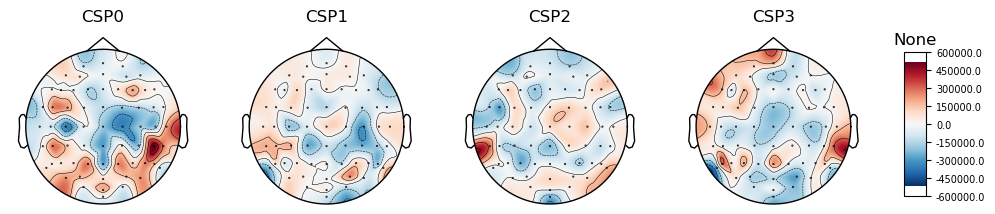

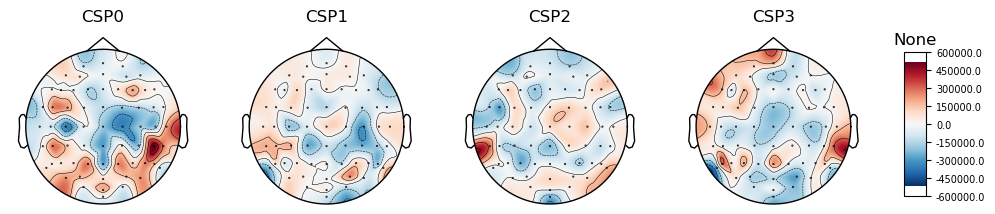

In [58]:
# Printing the results
class_balance = np.mean(class_label == class_label[0])
class_balance = max(class_balance, 1. - class_balance)
#print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),class_balance))

# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(csp_data, class_label)
csp.fit_transform(csp_data, class_label)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

In [59]:
print(np.shape(kenshou))

(80, 4, 2048)


In [61]:
class_data_cspfit = csp.transform(class_data)
class_data_cspfit = np.reshape(class_data_cspfit,(80,4*6144))

np.shape(class_data_cspfit)

(80, 24576)

In [63]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(class_data_cspfit,class_label, test_size=0.25,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train2,Y_train2)
print(model.score(X_test2, Y_test2))

0.65


In [64]:
params = {
    "C":np.arange(0.1,1,0.05),
    "kernel":["linear", "poly", "rbf", "sigmoid"],
    "gamma":np.arange(0.0001,0.1,0.05)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=3)

grid.fit(X_train2, Y_train2)

print(grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test2)
print(classification_report(Y_test2, pred))

0.7833333333333333
{'C': 0.9500000000000003, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.50      0.89      0.64         9

    accuracy                           0.55        20
   macro avg       0.62      0.58      0.52        20
weighted avg       0.64      0.55      0.51        20



In [65]:
params = {
    "C":np.logspace(-2,10,13),
    "kernel":[ "poly", "rbf", "sigmoid"],
    "gamma":np.logspace(-9,3,13)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(X_train2, Y_train2)

print("grid_best_score",grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test2)
print(classification_report(Y_test2, pred))

grid_best_score 0.7333333333333333
{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.50      0.89      0.64         9

    accuracy                           0.55        20
   macro avg       0.62      0.58      0.52        20
weighted avg       0.64      0.55      0.51        20

